In [1]:
# Libraries 
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Load the dataset
data = pd.read_csv("Donald Trumps Facebook Statuses.csv")

# information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4540 entries, 0 to 4539
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   status_id         4539 non-null   object 
 1   status_message    3794 non-null   object 
 2   link_name         2715 non-null   object 
 3   status_type       4160 non-null   object 
 4   status_link       2983 non-null   object 
 5   status_published  4160 non-null   object 
 6   num_reactions     4160 non-null   float64
 7   num_comments      4160 non-null   float64
 8   num_shares        4160 non-null   float64
 9   num_likes         4160 non-null   float64
 10  num_loves         4160 non-null   float64
 11  num_wows          4160 non-null   float64
 12  num_hahas         4160 non-null   float64
 13  num_sads          4160 non-null   float64
 14  num_angrys        4159 non-null   float64
dtypes: float64(9), object(6)
memory usage: 532.2+ KB


In [3]:
# showing the first few rows of the dataset
data.head()

,status_id,status_message,link_name,status_type,status_link,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,153080620724_10157915294545725,Beautiful evening in Wisconsin- THANK YOU for ...,Timeline Photos,photo,https://www.facebook.com/DonaldTrump/photos/a....,10/17/2016 20:56:51,6813.0,543.0,359.0,6178.0,572.0,39.0,17.0,0.0,7.0
1,153080620724_10157914483265725,The State Department's quid pro quo scheme pro...,NaN,video,https://www.facebook.com/DonaldTrump/videos/10...,10/17/2016 18:00:41,33768.0,3644.0,17653.0,26649.0,487.0,1155.0,75.0,191.0,5211.0
2,153080620724_10157913199155725,Crooked Hillary's State Department colluded wi...,NaN,video,https://www.facebook.com/DonaldTrump/videos/10...,10/17/2016 15:34:46,85627.0,8810.0,32594.0,73519.0,2943.0,1020.0,330.0,263.0,7552.0
3,153080620724_10157912962325725,"JournoCash: Media gives $382,000 to Clinton, $...","JournoCash: Media gives $382,000 to Clinton, $...",link,http://www.washingtonexaminer.com/journocash-m...,10/17/2016 14:17:24,22696.0,3665.0,5082.0,14029.0,122.0,2091.0,241.0,286.0,5927.0
4,153080620724_10157912187170725,"Exclusive: ""O'Keefe Video Sting Exposes 'Bird-...",O'Keefe Reveals 'Bird-Dogging' to Incite Viole...,link,http://www.breitbart.com/big-government/2016/1...,10/17/2016 12:03:19,40729.0,4905.0,17087.0,26472.0,178.0,2588.0,154.0,417.0,10922.0


## Use charts (histogram/bar graph) to display the distribution of types of statuses (photo, video, link, and status).

In [4]:
data['status_type'].value_counts()

status_type
photo                    1539
status                   1177
link                      763
video                     679
http://bit.ly/2duCRlw       1
event                       1
Name: count, dtype: int64

In [5]:
data = data[~data['status_type'].isin(['http://bit.ly/2duCRlw', 'event'])]
data['status_type'].value_counts()

status_type
photo     1539
status    1177
link       763
video      679
Name: count, dtype: int64

In [6]:
data = data.drop(columns=['status_id'])
data.dropna(subset=['num_likes'], inplace=True)
nan_count = data.isna().sum()
nan_count

status_message       366
link_name           1445
status_type            0
status_link         1177
status_published       0
num_reactions          0
num_comments           0
num_shares             0
num_likes              0
num_loves              0
num_wows               0
num_hahas              0
num_sads               0
num_angrys             0
dtype: int64

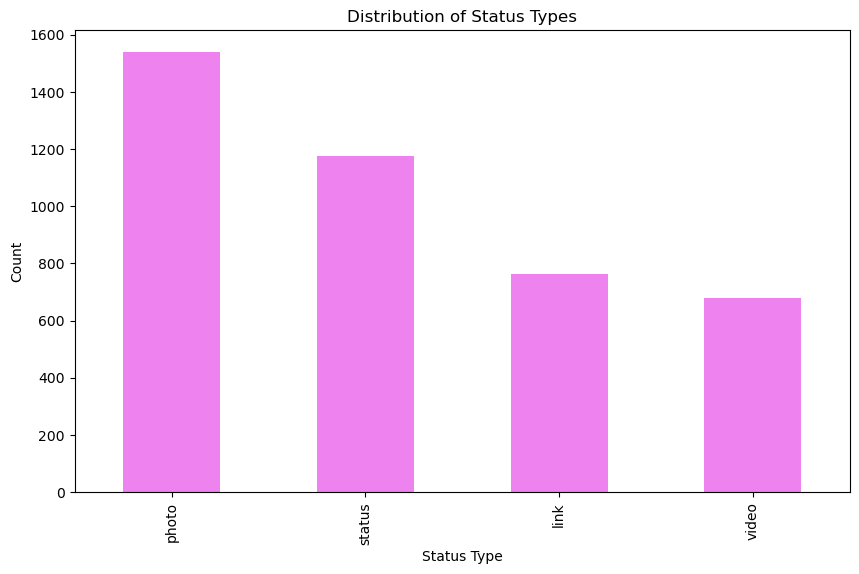

In [7]:
# Distribution of types of statuses (photo, video, link, and status)
status_types = data['status_type'].value_counts()
plt.figure(figsize=(10, 6))
status_types.plot(kind='bar', color='violet')
plt.title('Distribution of Status Types')
plt.xlabel('Status Type')
plt.ylabel('Count')
plt.show()

## Plot a chart showing the progression of likes, loves, and sads, and angrys over time.

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Assuming 'status_published' column is in datetime format, if not, convert it
data['status_published'] = pd.to_datetime(data['status_published'])

# Set 'status_published' as the index
data.set_index('status_published', inplace=True)

In [9]:
# Resample data to a weekly frequency (you can adjust this based on your data)
weekly_data = data.resample('W').sum()

# Decompose the time series into trend, seasonal, and residual components for each reaction
reactions = ['num_likes', 'num_loves', 'num_sads', 'num_angrys']

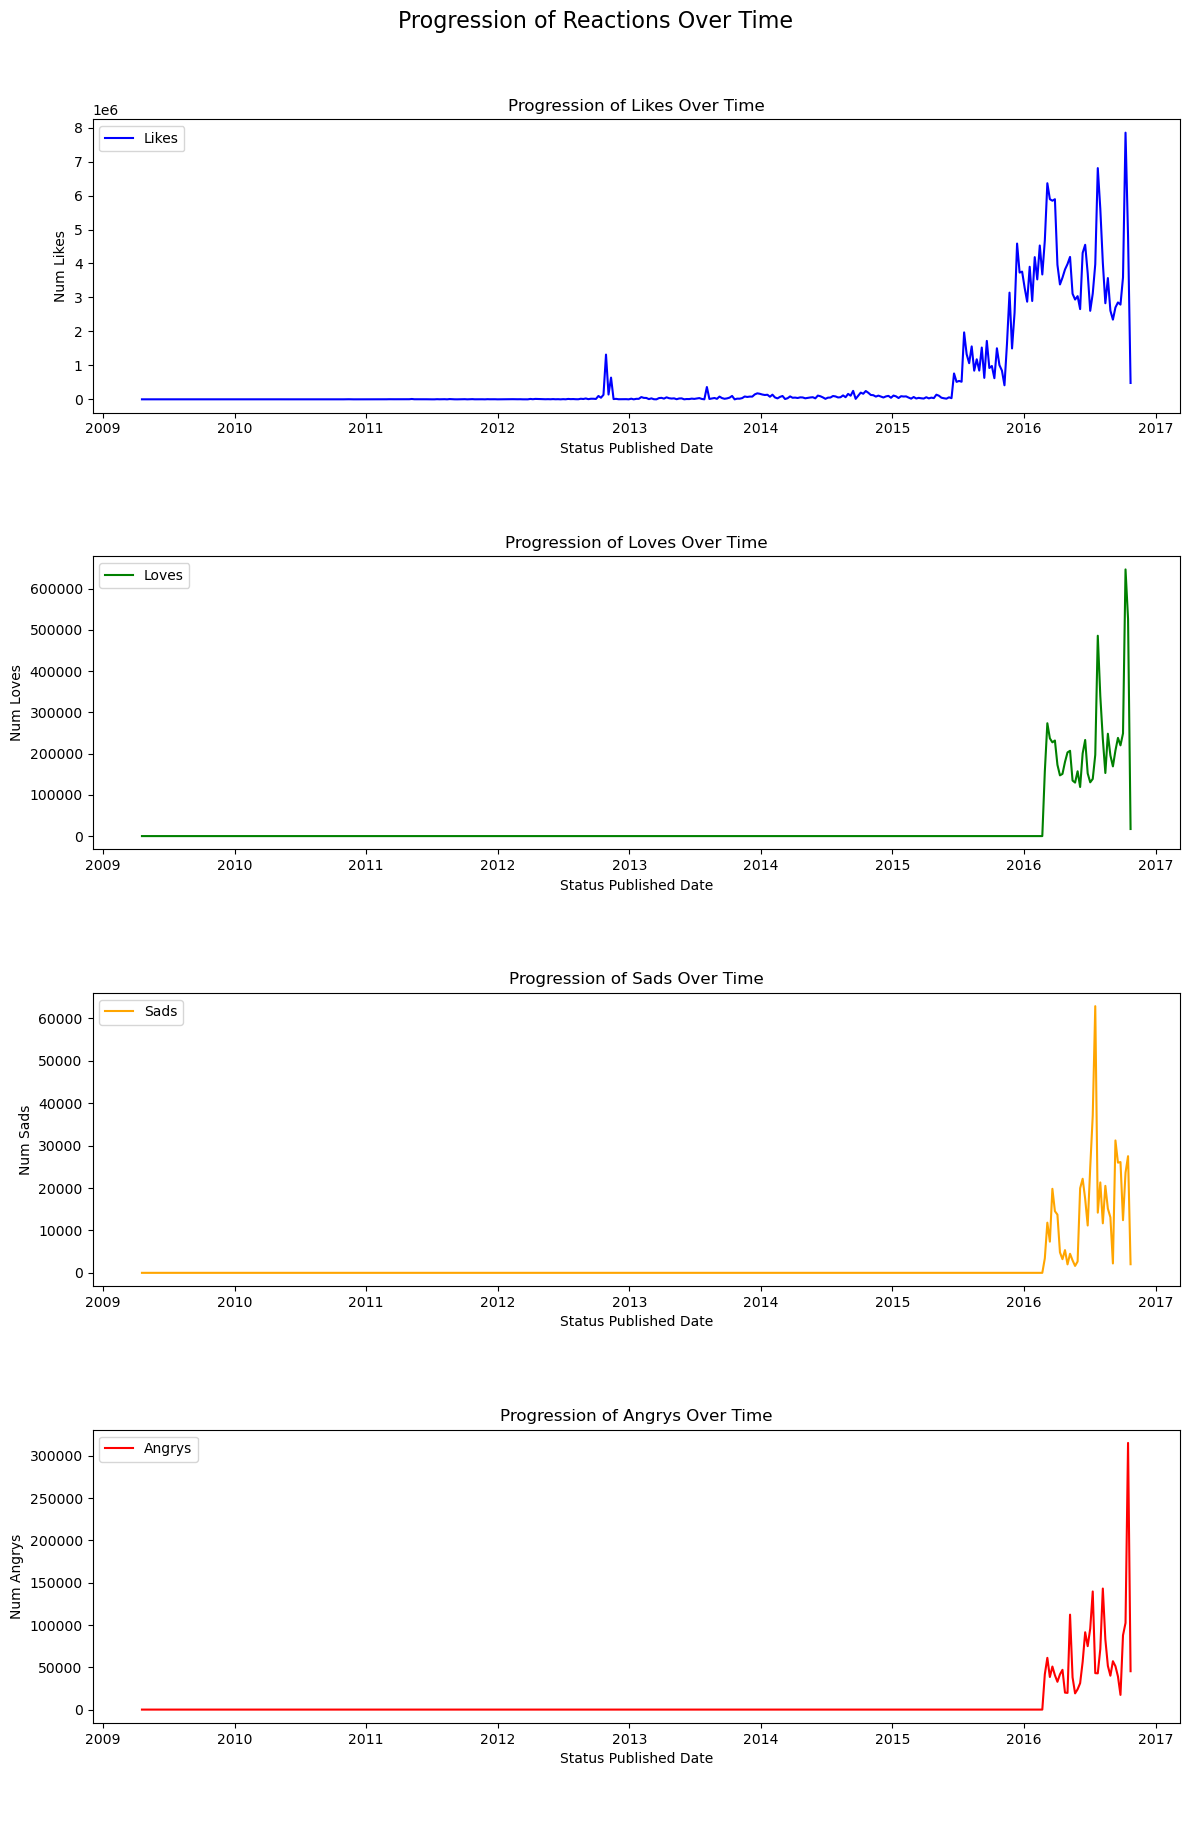

In [10]:
# Create subplots for each reaction
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 18), sharex=False)

# Plotting the progression of likes, loves, sads, and angrys over time
axes[0].plot(weekly_data.index, weekly_data['num_likes'], label='Likes', color='blue')
axes[1].plot(weekly_data.index, weekly_data['num_loves'], label='Loves', color='green')
axes[2].plot(weekly_data.index, weekly_data['num_sads'], label='Sads', color='orange')
axes[3].plot(weekly_data.index, weekly_data['num_angrys'], label='Angrys', color='red')

# Adjust subplot settings
for i, (ax, reaction) in enumerate(zip(axes, ['Likes', 'Loves', 'Sads', 'Angrys'])):
    ax.set_ylabel(f'Num {reaction}')
    ax.legend()
    ax.set_title(f'Progression of {reaction} Over Time')
    ax.set_xlabel('Status Published Date\n\n\n\n')

plt.suptitle('Progression of Reactions Over Time', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()


## What are the top reactions expressed by Trump’s Facebook audience?

## What are the themes (topics or top words) that generated a lot of shares?

## What are the themes (topics or top words) that generated a lot of num_reactions?